In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as plb

In [2]:
def f(x):
    return 3*x**2 - 4*x + 2

In [3]:
f(2)

6

In [4]:
x_rand = np.arange(-10,10,0.5)
y = f(x_rand)

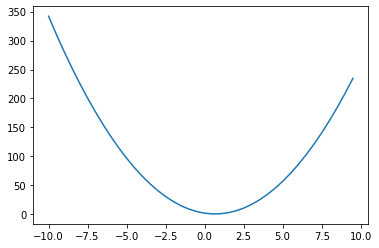

In [5]:
plt.plot(x_rand , y)

**Let's think**

- Now let's thing what is the derivative of this function at any point x?
- Check the defination of derivative, see what actually derivate tells us rather than just calculating it.

In [6]:
# Checking derivative

h = 0.000000001
x = 2.5
derivative = (f(x + h) - f(x))/h
derivative

11.000000910144081

## More than 2 inputs

In [7]:
h = 0.000001

#inputs

a = 2.0
b = 3.0
c = -1.5

# let's check d derivative w.r.t a
d1 = a * b + c
print('d1 : ', d1)
a += h
d2 = a * b + c
print('d2 : ', d2)

# let's check derivative now
print('slope : ', (d2 - d1)/h)

d1 :  4.5
d2 :  4.500003
slope :  3.000000000419334


In [8]:
# Let's do the same derivative check for b

# Checking the value of d without any change in b
print('d1 : ', d1)

# reversing the change that we did on a
a -= h

# doing some change in a
b += h

d3 = a * b + c
print('d3 : ',d3)

# let's check the derivative now

print('slope : ', (d3 - d1)/h)

d1 :  4.5
d3 :  4.500002
slope :  2.000000000279556


In [9]:
# Let's do the same derivative check for c

# Checking the value of d without any change in c
print('d1 : ', d1)

# reversing the change that we did on b
b -= h

# doing some change in c
c += h

d3 = a * b + c
print('d3 : ',d3)

# let's check the derivative now

print('slope : ', (d3 - d1)/h)

d1 :  4.5
d3 :  4.500001
slope :  1.000000000139778


## Value Object (Data Structure)

In [10]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op  # For operations
        self.label = label
        self.grad = 0.0
    
    # This repr function is very useful as if we will not use this value then we will
    # Get some kind of ugly ouput which is not understandable for end users
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Simply here we are just being precautious about other as if other is not of same 
        # instance of Value then we will make it one
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data + other.data, (self, other) , '+')
        return ans
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data * other.data, (self, other), '*')
        return ans
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t , (self, ) , 'tanh')
        return out

## Manual Backpropagation of Simple Expression

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

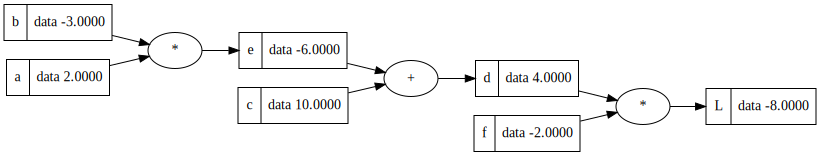

In [13]:
# Visualizing Forward Pass

draw_dot(L)

## Backward Pass

- As we know backward pass is mainly termed as Backpropagation.
- Backpropagation is simply derivative of final output with respect to it's leaf nodes
- Here with the term lead node I mean all those parameters which are not fixed from start. Some of the examples are Weights.

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [15]:
L.grad = 1.0

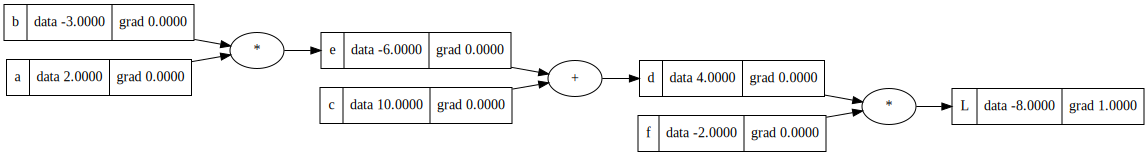

In [16]:
draw_dot(L)

In [17]:
def deriv():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L
    
    h = 0.00001
    
    # Derivative
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c;d.label = 'd'
    f = Value(-2.0, label='f')
    d.data += h
    L = d * f; L.label = 'L'
    L2 = L
    
    print((L2.data - L1.data)/h)
    
    
    
    

In [18]:
deriv()

-1.9999999999242843


In [19]:
d.grad = f.data
f.grad = d.data

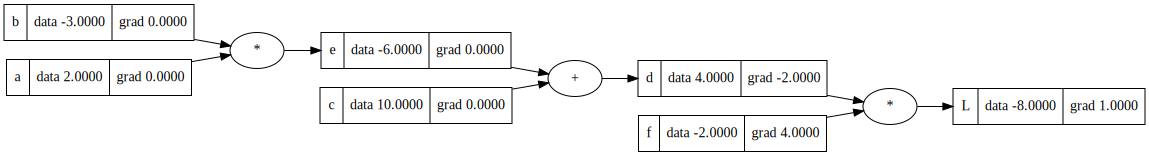

In [20]:
draw_dot(L)

In [21]:
s = draw_dot(L)
filename = s.render(filename='img/g4')

plb.savefig('filename.jpg')

<Figure size 432x288 with 0 Axes>

**Here comes the most interesting part of Backpropagation**

$ dL/dc $

- As we knew that c node don't actually interact with final output L but indirectly it does ,as c affects d and d affects L

***Here we can use Chain Rule of Calculus***

- $ dL/dc = (dL/dd) * (dd/dc) $ 

- As knew $d = c + e$ 

So the $dd/dc = 1.0$

**In the end - **

$dl/dc = (f.data) * 1.0$

In [22]:
c.grad = f.data
e.grad = f.data # same as of c

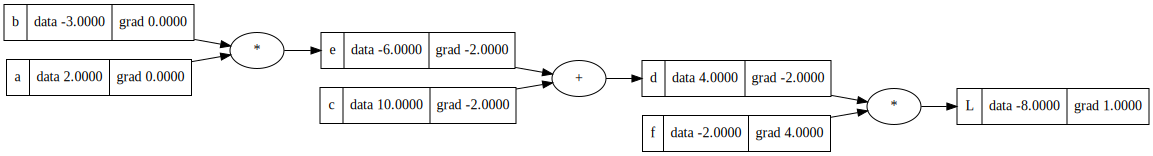

In [23]:
draw_dot(L)

- Now we will use that same chain rule of calculus here again 

* $ dL/db = dl/dd* dd/de * de/db $
* $e = a * b$

##### So with the help of calculus
* $de/db = a$

In [24]:
b.grad = (a.data) * (1.0) * (f.data)
a.grad = (b.data) * (1.0) * (f.data)

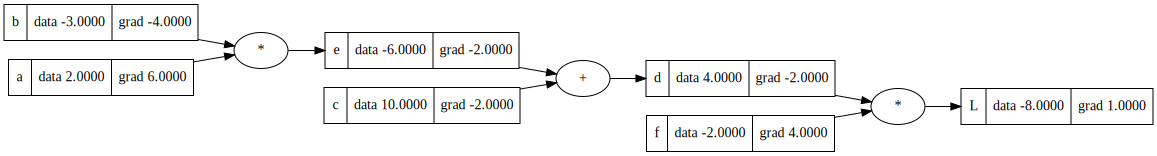

In [25]:
draw_dot(L)

In [26]:
# We can check our work with the help of deriv function whether we did correct or not

In [27]:
def deriv():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L
    
    h = 0.00001
    
    # Derivative
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c;d.label = 'd'
    f = Value(-2.0, label='f')
    d.data += h
    L = d * f; L.label = 'L'
    L2 = L
    
    print((L2.data - L1.data)/h)


In [28]:
deriv()

-1.9999999999242843


**This is what backpropagation is just a recursive application of chain rule backwards through the computation graph**

In [29]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


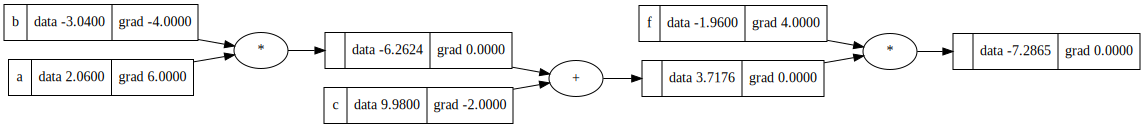

In [30]:
draw_dot(L)

## Manual Backpropagation of Neuron

### Tanh Function

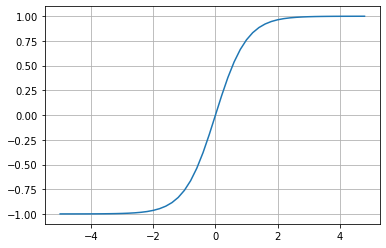

In [31]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5 , 5 , 0.2)))
plt.grid()

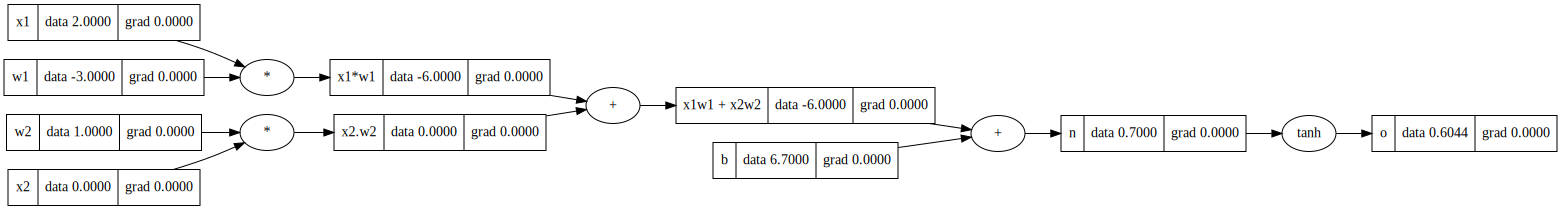

In [32]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

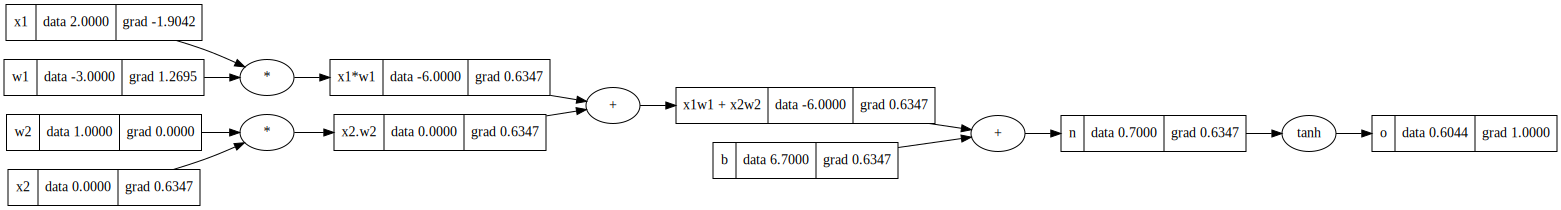

In [33]:
# Backpropagation

# base case, grad of o
o.grad = 1.0

# grad of n
# now we have to backpropagate by tanh ( do/dn )
# derivattive of tanh is 1 - tanh**2

n.grad = 1 - (o.data)**2


# for the derivate of x1w1x2w2 and b, we knew that + is just a distributor 
# of gradient, so simply the gradient of n will flow into both equally

x1w1x2w2.grad = n.grad * 1.0 # here 1.0 is grad of local derivative (simply by its own)
b.grad = n.grad * 1.0


# for grad of x1w1 and x2w2

x1w1.grad = 1.0 * x1w1x2w2.grad
x2w2.grad = 1.0 * x1w1x2w2.grad

# for grad of x1, w1, x2, w2
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

draw_dot(o)

## Implementing Backward Function For Each Operation

In [160]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    
# This repr function is very useful as if we will not use this value then we will
# Get some kind of ugly ouput which is not understandable for end users

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out


# as with just __mul__ function we can't deal with 2 * a
# with that we can only deal with a * 2
# so we need __rmul__ which will check in 2 * a whether a knows or not
# how to multiply a and 2.
    
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
# backpropagation function for whole expression in once
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

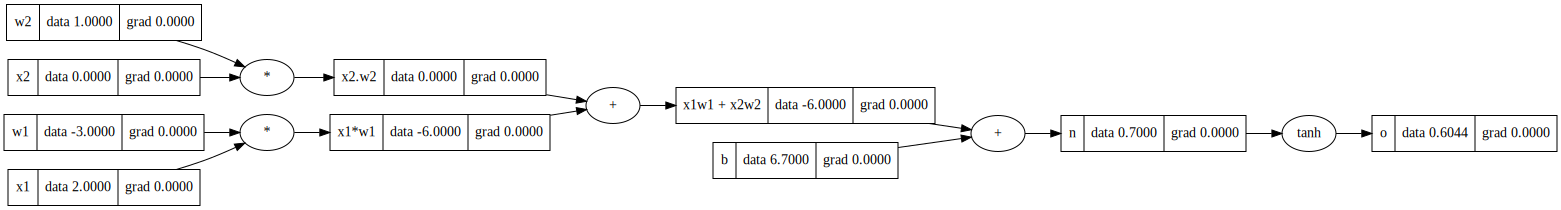

In [35]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

In [36]:
# base case
o.grad = 1.0

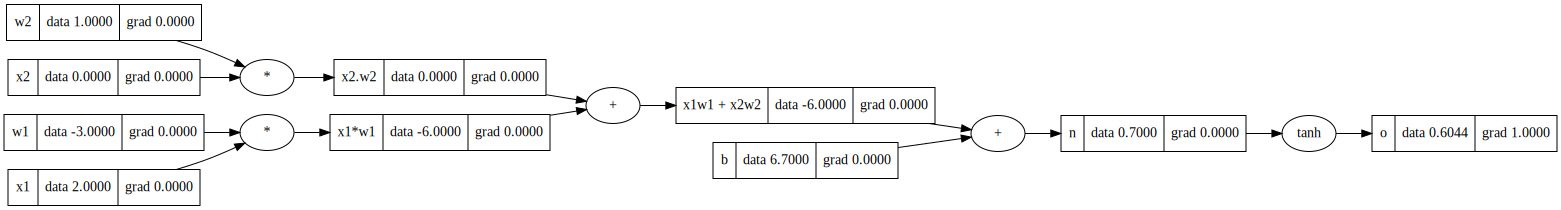

In [37]:
draw_dot(o)

In [38]:
o._backward()

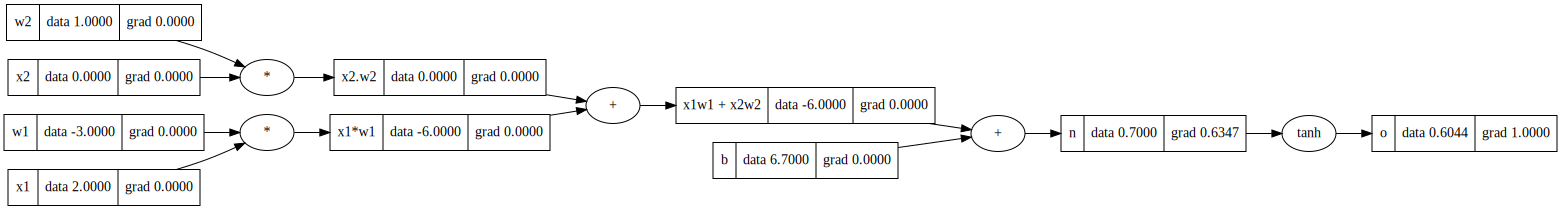

In [39]:
draw_dot(o)

In [40]:
n._backward()

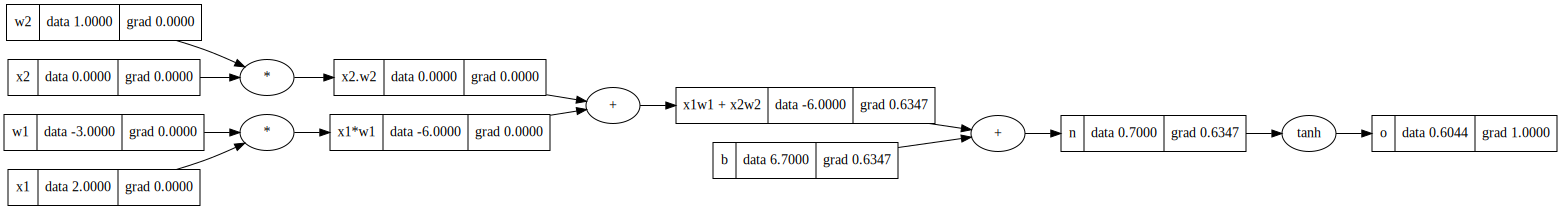

In [41]:
draw_dot(o)

In [42]:
b._backward()

In [43]:
x1w1x2w2._backward()

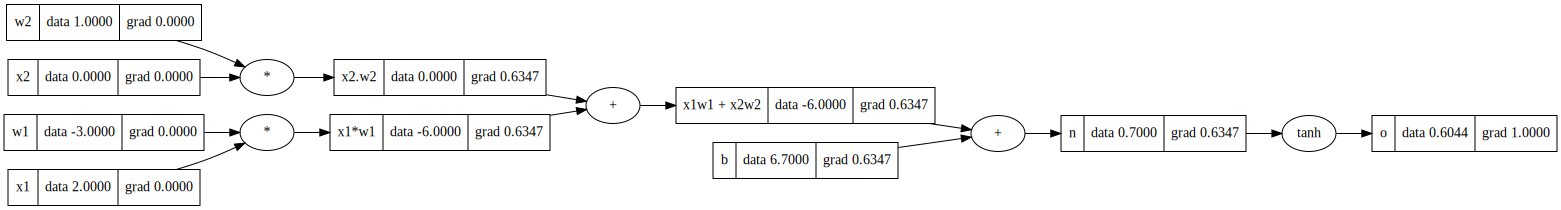

In [44]:
draw_dot(o)

In [45]:
x1w1._backward()
x2w2._backward()

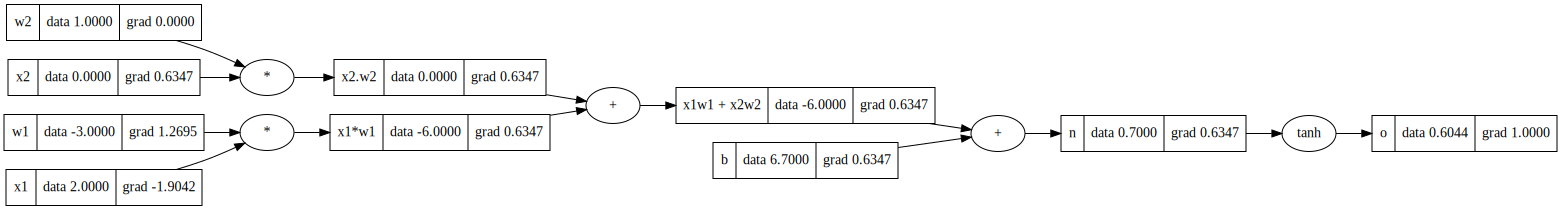

In [46]:
draw_dot(o)

- ***Simpy we just went backward from output till input taking derivative.***

## Implementing Backward Function For a Whole Expression

- We can move in one side using topological order

In [47]:
# let's make topological orders node list

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)    
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.7),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

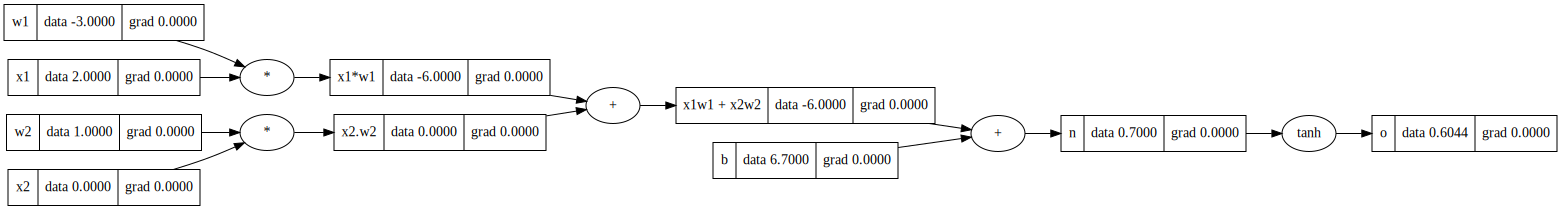

In [48]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

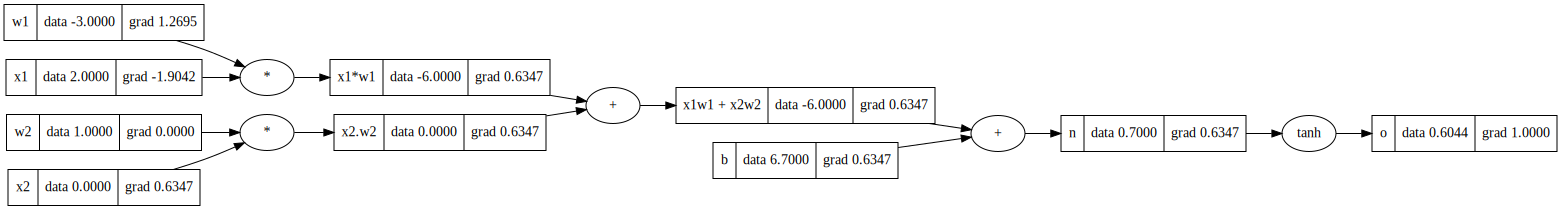

In [49]:
# Backward Pass

o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)    
        topo.append(v)
build_topo(o)


for node in reversed(topo):
    node._backward()

    
draw_dot(o)

In [50]:
o.backward()

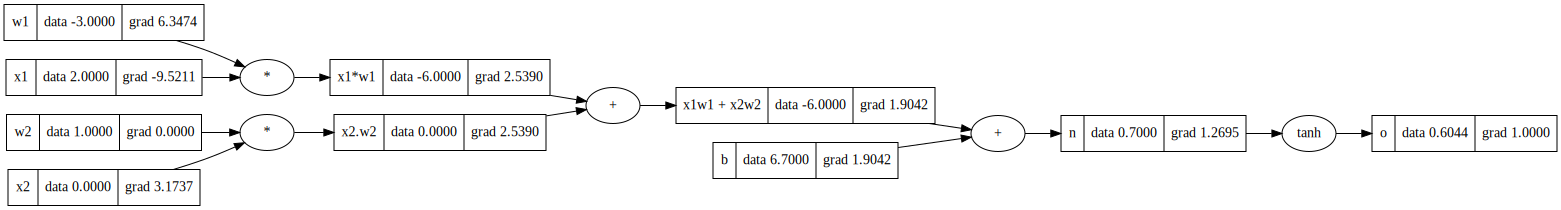

In [51]:
draw_dot(o)

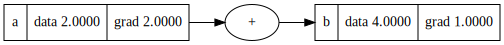

In [52]:
a = Value(2.0 , label = 'a')
b = a + a; b.label = 'b';
b.backward()
draw_dot(b)

- Instead of setting those gradients value we are accumulating them using  += signs this simply helps us as if we have a repetive nodes then it will have issue as the self and other grad will be of same node so same gradient will be done twice of the same node rather than adding them as for example $b = a + a$ in this equation $db/da$ will be equal to 2 but if we ill go with our same code in which we are just setting values then it will give 1 as an  output.

## Implementing tanh function by breaking it into pieces

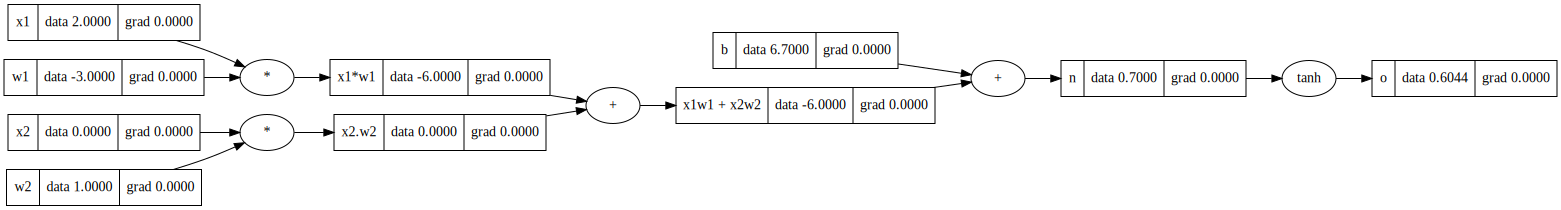

In [53]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

In [54]:
o.backward()

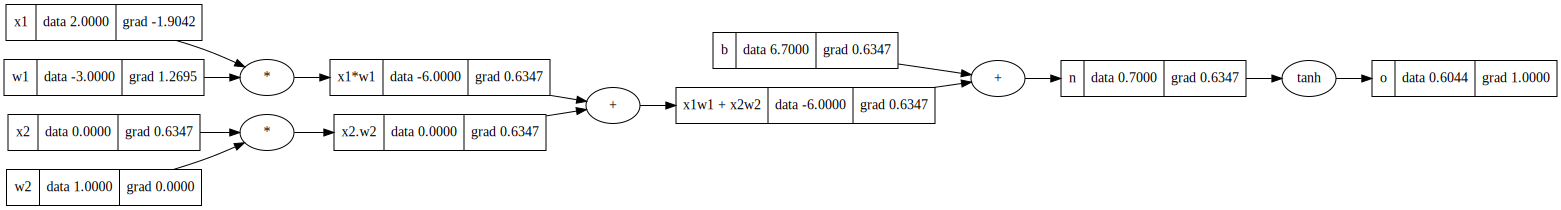

In [55]:
draw_dot(o)

**Previously we did without breaking tanh, now let's do it by that**

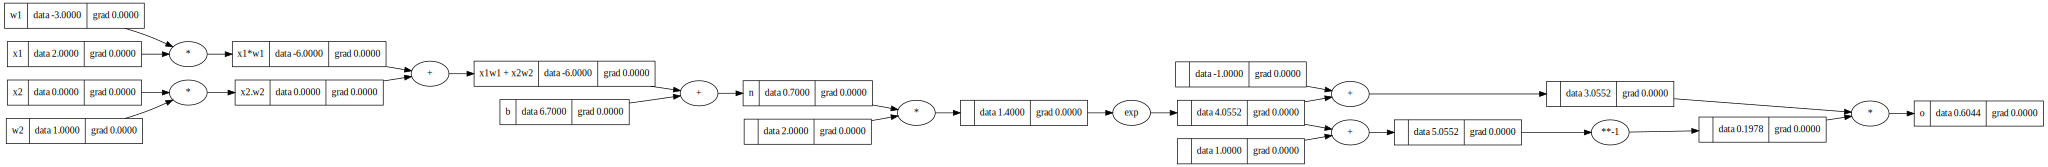

In [56]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

# _____________________

e = (2 * n).exp()
o = (e - 1)/(e + 1)

#_____________________


o.label = 'o'

# checking graph

draw_dot(o)

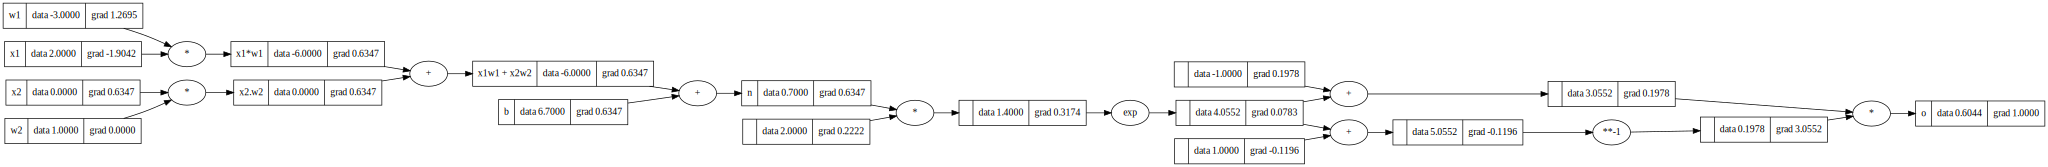

In [57]:
o.backward()
draw_dot(o)

- ***In simple words we have input and we perform functions over that input and we eventually get some output. If we will perform backpropagation then it does not matter what the function is and even we if we will use different function as many time possible from tiny function (as we breaked the tanh) till complex one like tanh we will get the same gradient all the time.***

# Performing all these works using PYTORCH

In [58]:
import torch


# here we are changing dtype to double as by default in python dtype is of float64/double but in pytorch tensor it is of float32
# so it's better to change it to double() to save ourselves from any other future issues

# by default pytorch assumes to not take gradient, that's why we are explicitly enabling it
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.881373587019]).double()      ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# here `.item()` is simply taking the single element tensor out of all those tensor and then extracting the element out of it leaving tensor behind
print('o  : ' , o.data.item())
o.backward()


print('-------------------------')

print('x1 : ', x1.grad.item())
print('x2 : ', x2.grad.item())
print('w1 : ', w1.grad.item())
print('w2 : ', w2.grad.item())
print('b  : ', b.grad.item())

o  :  0.7071066904050358
-------------------------
x1 :  -1.5000003851533106
x2 :  0.5000001283844369
w1 :  1.0000002567688737
w2 :  0.0
b  :  0.5000001283844369


In [59]:
# Working of .item()

print("o : " , o) 
print("----")
print("o.item() : ", o.item())
print("----")
print("o.data.item() : ", o.data.item())

o :  tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
----
o.item() :  0.7071066904050358
----
o.data.item() :  0.7071066904050358


## Building Neural Network

***Neural Networks are just a special class of mathematical expressions.***

In [190]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1 , 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1 , 1))
    
    def __call__(self , x):
        # w*x + b ,  this is what we are simply implementing
        act = sum((wi*xi for wi,xi in zip(self.w , x)) , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self , nin , nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self , x):
        # here i simply just took one neuron out of that neurons list and 
        # calculated act of that and stored it into list named outs
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # using list comprehension we can write this code
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
        # but it not advised to use it for understanding purpose so let's write basic code
 
       
        """ 
        param = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            param.extend(ps)
        return param
        """ 
class MLP:
    
    def __init__(self, nin , nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i + 1]) for i in range(len(nouts))]
    
    
    def __call__(self , x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
       return [p for layer in self.layers for p in layer.parameters()]
       """
       ps = []
       for layer in self.layers:
           l = layer.parameters();
           ps.extend(l)
        return ps
       """

In [191]:
x = [2.0 , 3.0 , -1.0]
n = MLP(3 ,[4 , 4 , 1])
n(x)

Value(data=0.5671955142292437)

- **As if we would just use call function of the Neuron class this is good enough for making a single neuron**
- **Now with the help of this Neuron class i will create layer of neurons which include hidden layers as well as input & output layer**

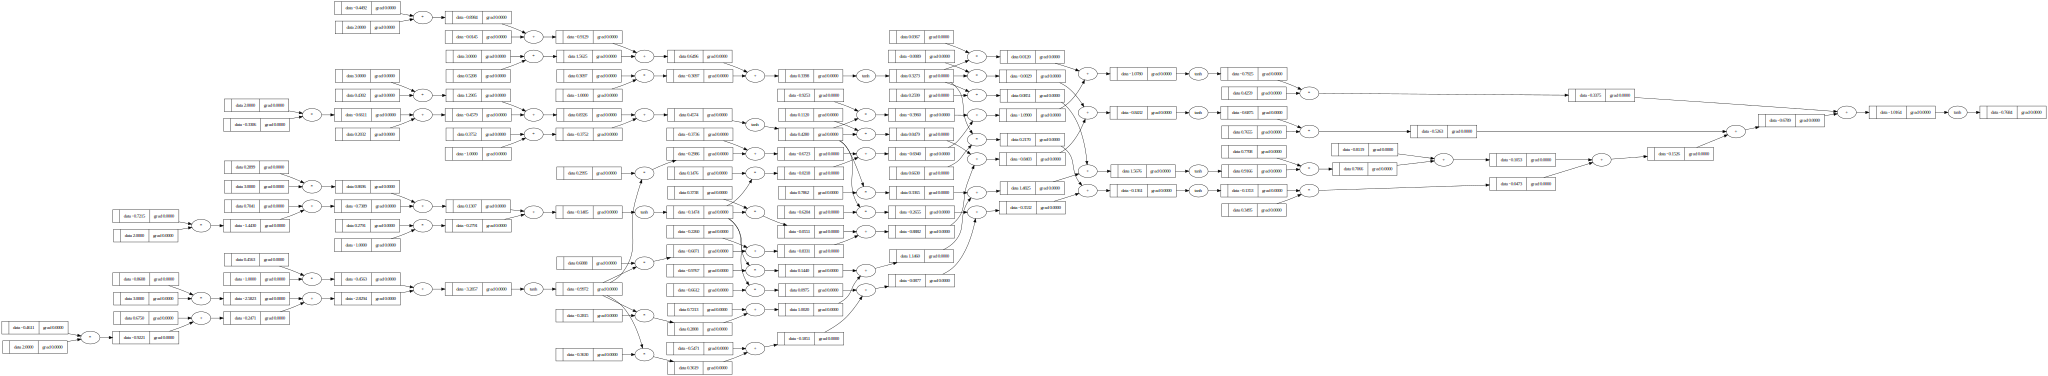

In [163]:
draw_dot(n(x))

In [215]:
# input value
xs = [[2.0 , 3.0 , -1.0],
      [1.0 , 2.5 , 4.3],
      [2.3 , -7.4 , 4.8],
      [3.4 ,  6.7 ,  9.0]]

# target value
ys = [1.0 , -1.0 , 1.0 , -1.0]

In [197]:
loss = [(yout - ygt)**2 for ygt , yout in zip(ys , ypred)]

In [198]:
loss

[Value(data=0.18731972290328874),
 Value(data=2.000601032917205),
 Value(data=0.24631448016110774),
 Value(data=2.449675636128029)]

In [199]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.883910872109631)

In [226]:
loss.backward()

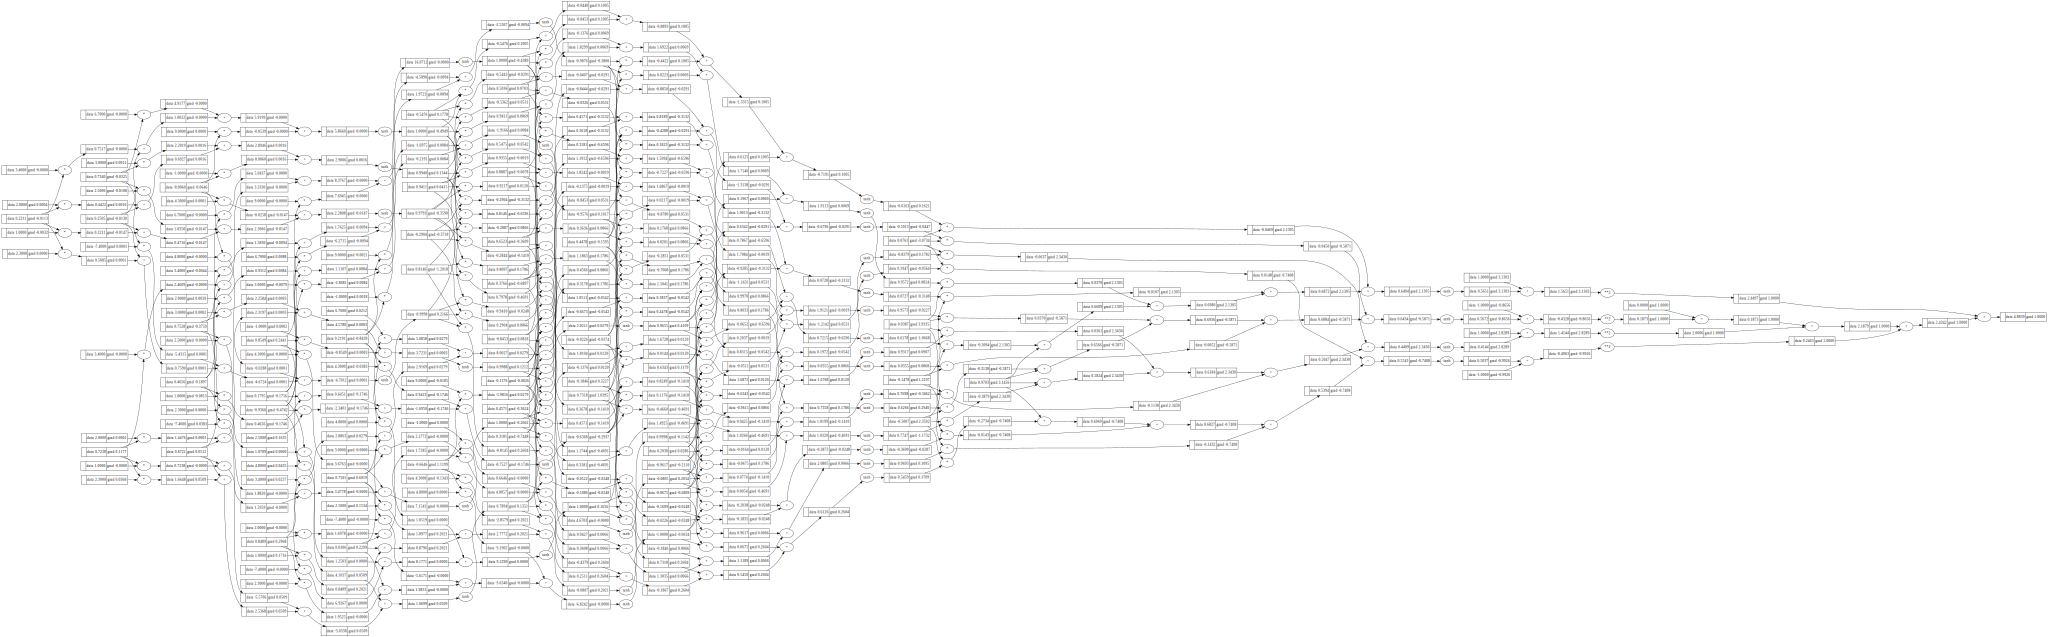

In [201]:
# graph will be very big as compared to previous one as we are here doing 4 forward passes and all those single computations

draw_dot(loss)

In [227]:
# As we know MLP has layer and inside that layer we have neurons and every single neuron has some weights

n.layers[0].neurons[0].w[0]

Value(data=0.49671385831725506)

In [228]:
# as now we also have grad with the help of that we can get that grad of weights

n.layers[0].neurons[0].w[0].grad

-0.011347519561196243

- Now as we can see the grad of the particular weight of the particular neruon of the particular layer is positive, so it simply means that the influence of this weight is also positive.
- Remember one more point, that the grdient to the input data is not important to us.

In [229]:
len(n.parameters())

41

In [230]:
# Code for parameter updation

for p in n.parameters():
    p.data += -0.01 * p.grad

In [231]:
# New Loss
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.999997908398802)

## Initialising Everything Again

In [244]:
n = MLP(3 , [4 , 4 , 1])

In [245]:
# input value
xs = [[2.0 , 3.0 , -1.0],
      [1.0 , 2.5 , 4.3],
      [2.3 , -7.4 , 4.8],
      [3.4 ,  6.7 ,  9.0]]

# target value
ys = [1.0 , -1.0 , 1.0 , -1.0]

In [246]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    loss.backward()
    
    # update
    
    for p in n.parameters():
        p.data = -0.01 * p.grad
    
    print(k , loss.data)
    

0 6.452683926631169
1 4.000167130825037
2 4.000142771024381
3 4.000120787546528
4 4.000100820543539
5 4.000082563663194
6 4.000065755833906
7 4.000050174308774
8 4.000035628775481
9 4.0000219563683075
10 4.000009017443688
11 3.999996692001952
12 3.9999848766559385
13 3.9999734820623667
14 3.9999624307448123
15 3.99995165524801
16 3.9999410965724866
17 3.9999307028463487
18 3.999920428197658
19 3.9999102317964756


In [247]:
loss

Value(data=3.9999102317964756)


### Let's check with another data

In [279]:
x = [2.0 , 3.0 , -1.0]
n = MLP(3 , [4 , 4 , 1])
n(x)

Value(data=-0.9471328373578329)

In [280]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [286]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    
    for p in n.parameters():
        p.data = -0.1 * p.grad
    
    print(k , loss.data)
    

0 4.000000000352267
1 4.000000000225451
2 4.000000000144288
3 4.000000000092345
4 4.0000000000591
5 4.000000000037824
6 4.000000000024207
7 4.000000000015493
8 4.000000000009916
9 4.000000000006347
10 4.000000000004062
11 4.0000000000026
12 4.000000000001664
13 4.000000000001065
14 4.000000000000681
15 4.000000000000436
16 4.000000000000279
17 4.000000000000178
18 4.000000000000115
19 4.000000000000074


In [287]:
ypred

[Value(data=1.3524327871512455e-07),
 Value(data=1.3524327871512455e-07),
 Value(data=1.3524327871512455e-07),
 Value(data=1.3524327871512455e-07)]